Requisitos para o funcionamento: OpenCV, MediaPipe e Numpy.

In [ ]:
!pip install opencv-python==4.6.0.66
!pip install mediapipe==0.8.11
!pip install numpy==1.22.3

In [14]:
import cv2
import mediapipe as mp
import numpy as np
import time

In [15]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

## Análise de Olhos
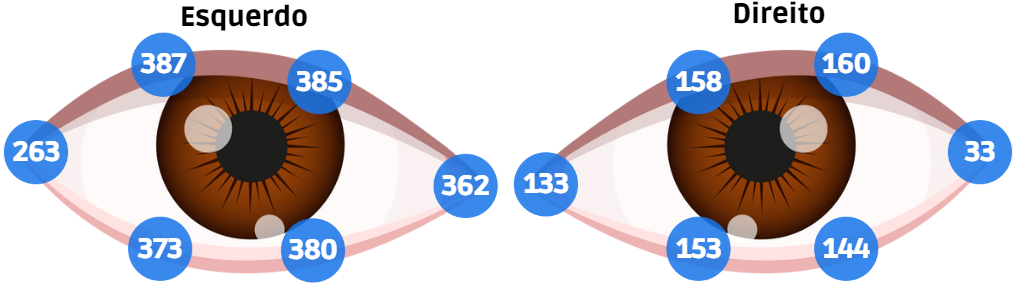

In [ ]:
pontos_olho_esquerdo = [385, 380, 387, 373, 362, 263]
pontos_olho_direito = [160, 144, 158, 153, 33, 133]
pontos_olhos = pontos_olho_esquerdo + pontos_olho_direito
pontos_olhos

- Cálculo EAR - Eye Aspect Ratio

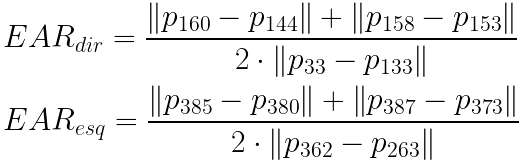

In [17]:
def calcular_media_ear(face, pontos_esquerdo, pontos_direito):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])
        face_esquerdo = face[pontos_esquerdo, :]
        face_direito = face[pontos_direito, :]

        ear_esquerdo = (
            np.linalg.norm(face_esquerdo[0] - face_esquerdo[1]) + np.linalg.norm(face_esquerdo[2] - face_esquerdo[3])
            / (2 * np.linalg.norm(face_esquerdo[4] - face_esquerdo[5]))
        )

        ear_direito = (
            np.linalg.norm(face_direito[0] - face_direito[1]) + np.linalg.norm(face_direito[2] - face_direito[3])
            / (2 * np.linalg.norm(face_direito[4] - face_direito[5]))
        )
    except:
        ear_esquerdo = ear_direito = 0.0
    
    media_ear = (ear_esquerdo + ear_direito) / 2

    return media_ear

## Análise de Boca
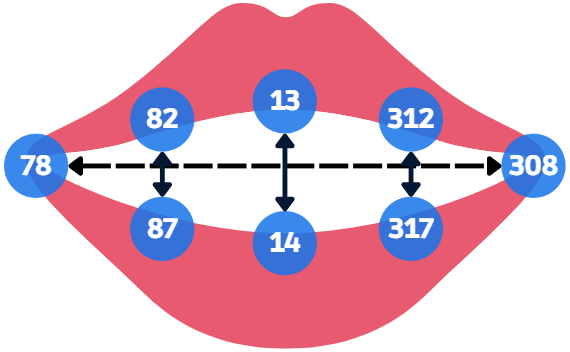

In [ ]:
pontos_boca = [82, 87, 13, 14, 312, 317, 78, 308]
pontos_boca

- Calcular MAR - Mouth Aspect Ratio

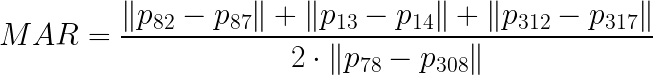

In [19]:
def calcular_mar(face, pontos_boca):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])
        face_boca = face[pontos_boca, :]

        mar = (
            np.linalg.norm(face_boca[0] - face_boca[1]) + np.linalg.norm(face_boca[2] - face_boca[2]) +
            np.linalg.norm(face_boca[4] - face_boca[5])
        ) / (2 * np.linalg.norm(face_boca[6] - face_boca[7]))
    except:
        mar = 0.0
    
    return mar

Abrir a camera e fazer captura continuamente, em tempo real, com escape para finalizar a captura. Realiza a identificação dos pontos faciais.

In [ ]:
limiar_ear = 0.17
limiar_mar = 0.11
blinks = 0
blinks_atual = 0
blinks_per_min = 0
control_blinks = False
sleep = False
start_time = time.time()
cap = cv2.VideoCapture(1)

with mp_face_mesh.FaceMesh(min_detection_confidence=0.9, min_tracking_confidence=0.9) as facemesh:
    while cap.isOpened():
        success, frame = cap.read()

        if not success:
            print('Câmera não iniciada.\n')
            continue
        else:
            comprimento, largura, _ = frame.shape
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            saida = facemesh.process(frame)
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

            try:
                for face_landmarks in saida.multi_face_landmarks:
                    mp_drawing.draw_landmarks(
                        frame,
                        face_landmarks,
                        mp_face_mesh.FACEMESH_CONTOURS,
                        landmark_drawing_spec=mp_drawing.DrawingSpec(
                            (255, 10, 10), 1, 1),
                        connection_drawing_spec=mp_drawing.DrawingSpec(
                            (255, 10, 10), 1)
                    )

                    face = face_landmarks.landmark
                    for id_coord, coord_xyz in enumerate(face):

                        # identificar os olhos
                        if id_coord in pontos_olhos:
                            coord_cv = mp_drawing._normalized_to_pixel_coordinates(
                                coord_xyz.x, coord_xyz.y, largura, comprimento
                            )

                            cv2.circle(frame, coord_cv, 2, (0, 0, 255), -1)
                        
                        #identificar a boca
                        if id_coord in pontos_boca:
                            coord_cv = mp_drawing._normalized_to_pixel_coordinates(
                                coord_xyz.x, coord_xyz.y, largura, comprimento
                            )

                            cv2.circle(frame, coord_cv, 2, (0, 0, 255), -1)

                    # verificar abertura dos olhos - EAR
                    media_ear = calcular_media_ear(face, pontos_olho_esquerdo, pontos_olho_direito)
                    cv2.rectangle(frame, (0, 1), (295, 165), (0, 0, 0), -1)
                    cv2.putText(
                        frame, "EAR: {} - {}".format(
                        round(media_ear, 2), 'Open' if media_ear >= limiar_ear else 'Closed'), (1, 24),
                        cv2.FONT_HERSHEY_DUPLEX, 0.9, (0, 0, 255), 2
                    )

                    # verificar abertura da boca - MAR
                    mar = calcular_mar(face, pontos_boca)
                    cv2.putText(
                        frame, "MAR: {} - {}".format(
                        round(mar, 2), 'Open' if mar >= limiar_mar else 'Closed'), (1, 50), cv2.FONT_HERSHEY_DUPLEX,
                        0.9, (0, 0, 255), 2
                    )

                    # incrementar quantidade de piscadas dos olhos
                    if media_ear < limiar_ear:
                        blinks = blinks + 1 if control_blinks is False else blinks
                        control_blinks = True
                    else:
                        control_blinks = False

                    # se fechar os olhos e boca inicia a contagem de tempo e classifica como dormindo
                    if media_ear < limiar_ear and mar < limiar_mar:
                        t_inicial = time.time() if sleep is False else t_inicial
                        sleep = True
                    # se abrir os olhos classifica dormindo como False
                    if (sleep is True and media_ear >= limiar_ear) or (media_ear < limiar_ear and mar >= limiar_mar):
                        sleep = False

                    t_final = time.time()
                    tempo = t_final - t_inicial if sleep is True else 0.0
                    cv2.putText(
                        frame, "TIME: {}".format(
                        round(tempo, 2)), (1, 80), cv2.FONT_HERSHEY_DUPLEX,
                        0.9, (0, 0, 255), 2
                    )

                    # verificar qtd de piscadas por minuto
                    if(round(t_final - start_time) == 60):
                        blinks_per_min = blinks - blinks_atual
                        blinks_atual = blinks
                        start_time = time.time()

                    # Exibir quantidade de piscadas
                    cv2.putText(
                        frame, "BLINKS: {}".format(blinks), (1, 120),
                        cv2.FONT_HERSHEY_DUPLEX, 0.9, (0, 0, 255), 2
                    )

                    # Exibir quantidade de piscadas POR MINUTO
                    cv2.putText(
                        frame, "BLINKS /MIN: {}".format(blinks_per_min), (1, 150),
                        cv2.FONT_HERSHEY_DUPLEX, 0.9, (0, 0, 255), 2
                    )

                # ALERTA DE SONO: se passar de 1.5seg com olhos fechados
                if tempo >= 1.5:
                    cv2.rectangle(frame, (30, 400),
                                  (610, 452), (109, 233, 219), -1)
                    cv2.putText(
                        frame, "DORMINDO!", (80,
                                             435), cv2.FONT_HERSHEY_DUPLEX,
                        0.85, (58, 58, 55), 1
                    )

            except:
                pass

            cv2.imshow('Captura em Tempo Real', frame)
            if cv2.waitKey(10) & 0xFF == ord('c'):
                print('Câmera encerrada.\n')
                break

cap.release()
cv2.destroyAllWindows()
